In [1]:
from MuonSimulationHelpers import *
from matplotlib.pyplot import cm

def muon_rates(simulation):
    mu_weights = np.array(simulation.data['muon_weights'])
    mu_detector_distances = np.array(simulation.data['muon_lengths'])
    mu_surface_distances = np.array(simulation.data['lepton_surface_distances'])
    mu_distances = np.array([min(x,y) for x,y in zip(mu_detector_distances,mu_surface_distances)])
    mu_profile = np.array([simulation.data['muon_transverse_profile_x'],
                           simulation.data['muon_transverse_profile_y']]).T
    
    def Xf(E,rho=1):
        return 1./(rho * 5e-4) * np.log(1 + 2e-3 * E)
    
    mu_ranges = Xf(simulation.data["E_lep"],rho=2.7)
    mu_weights *= mu_distances<mu_ranges
    mu_radius = np.sqrt(np.sum(mu_profile**2,axis=-1))
    rate = {}
    rate_err = {}
    for rad_cut in [5,10,15]:
        fid_weights = (mu_weights * (mu_radius<rad_cut))
        rate[rad_cut] = sum(fid_weights)
        rate_err[rad_cut] = np.sqrt(np.sum(fid_weights**2))
    return rate,rate_err


In [3]:
def total_rate(light_simulation,charm_simulation):
    rate_l,rate_l_err = muon_rates(light_simulation)
    rate_c,rate_c_err = muon_rates(charm_simulation)
    total_rates = {}
    total_err = {}
    for k in rate_l.keys():
        total_rates[k] = rate_l[k] + rate_c[k]
        total_err[k] = np.sqrt(rate_l_err[k]**2 + rate_c_err[k]**2)
    return rate_l,rate_l_err,rate_c,rate_c_err,total_rates,total_err

In [5]:
light_generators = ["EPOSLHC","DPMJET","SIBYLL","QGSJET","PYTHIA8"]
charm_generators = ["BKSS","BKRS","SIBYLL","BDGJKR","MS"]

generator_rates = {}

for gen_l,gen_c in zip(light_generators,charm_generators):
    light_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_light.parquet'%gen_l)
    charm_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_%s_charm.parquet'%gen_c)
    generator_rates[(gen_l,gen_c)] = total_rate(light_simulation,charm_simulation)



5 3934
10 14736
15 29356
5 7446
10 22459
15 37899
5 4205
10 15294
15 29933
5 8051
10 24335
15 41684
5 4331
10 15383
15 29930
5 1051
10 4143
15 9132
5 4209
10 14976
15 29293
5 6313
10 19891
15 32959
5 4071
10 14844
15 29200
5 5343
10 17165
15 31352


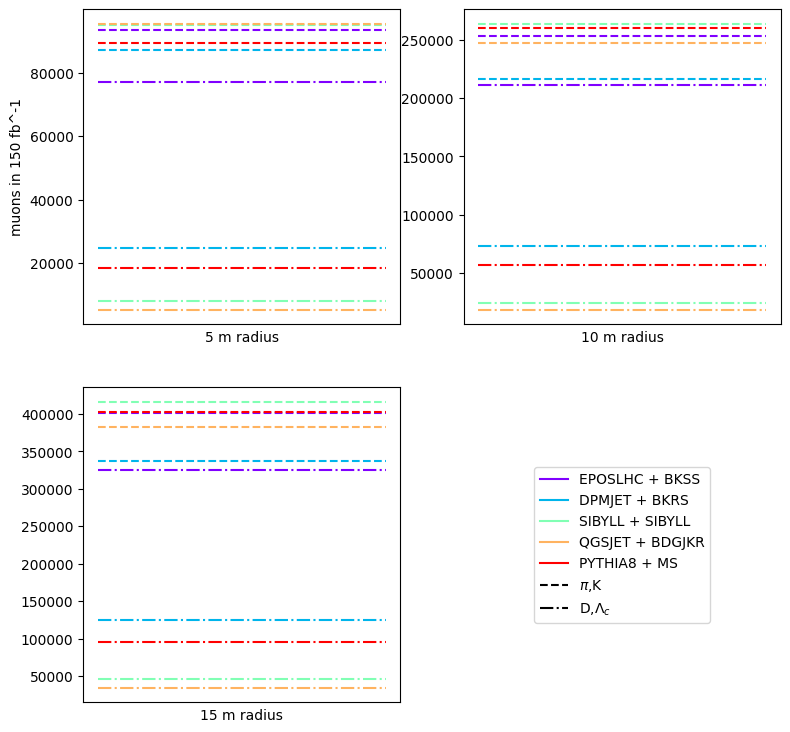

In [9]:
color = iter(cm.rainbow(np.linspace(0, 1, len(generator_rates))))


fig,ax = plt.subplots(2,2,figsize=(9,9))
for k,(rate_l,rate_l_err,
       rate_c,rate_c_err,
       total_rates,total_err) in generator_rates.items():
    c = next(color)
    for i,rad_cut in enumerate(rate_l.keys()):
        ax_key = (0 if i<2 else 1,i%2)
        ax[ax_key].plot([0,1],[rate_l[rad_cut],rate_l[rad_cut]],ls='--',color=c)
        ax[ax_key].plot([0,1],[rate_c[rad_cut],rate_c[rad_cut]],ls='-.',color=c)
        #ax[ax_key].plot([0,1],[total_rates[rad_cut],total_rates[rad_cut]],color=c)
        for rate,rate_err in zip([#rate_l,
                                  #rate_c,
                                  #total_rates
                                 ],
                                 [#rate_l_err,
                                  #rate_c_err,
                                  #total_err
                                 ]):
            ax[ax_key].fill_between([0,1],
                                    [rate[rad_cut]-rate_err[rad_cut],
                                     rate[rad_cut]-rate_err[rad_cut]],
                                    [rate[rad_cut]+rate_err[rad_cut],
                                     rate[rad_cut]+rate_err[rad_cut]],
                                    color=c,alpha=0.5)
    ax[1,1].plot([],[],color=c,label="%s + %s"%(k[0],k[1]))
#ax[1,1].plot([],[],color="black",label="total")
ax[1,1].plot([],[],color="black",ls='--',label=r"$\pi$,K")
ax[1,1].plot([],[],color="black",ls='-.',label=r"D,$\Lambda_c$")
ax[1,1].axis("off")
for i,rad_cut in enumerate([5,10,15]):
    ax_key = (0 if i<2 else 1,i%2)
    ax[ax_key].set_xticks([])
    ax[ax_key].set_xlabel("%d m radius"%rad_cut)
    #ax[ax_key].semilogy()
ax[0,0].set_ylabel("muons in 150 fb^-1")
ax[1,1].legend(loc="center")
plt.savefig("MuonRateComparison.pdf",dpi=100)
plt.show()



In [14]:
np.sqrt(1e5)/1e5

0.00316227766016838